In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm
from datetime import datetime, timedelta
from transform import get_power, get_spectrum
import matplotlib.pyplot as plt

In [2]:
dir_name = "2nd_test"
filenames = sorted(os.listdir(dir_name))

## 获取时间戳

In [3]:
dt = [datetime.strptime(x, "%Y.%m.%d.%H.%M.%S") for x in filenames]

## 获取波形数据

In [4]:
res = list()
for filename in tqdm(filenames):
    df = pd.read_csv("{}/{}".format(dir_name, filename), sep='\t', header=None)
    res.append(df.values[:, 0])

100%|███████████████████████████████████████████████████████████████████████████████| 984/984 [00:08<00:00, 118.11it/s]


In [5]:
data = np.array(res)

In [6]:
data.shape

(984, 20480)

## 获取频谱数据

In [7]:
from functools import partial

In [8]:
SF = 20000

In [9]:
spect = np.apply_along_axis(partial(get_spectrum, sf=SF), 1, data[:, :SF])[:, 1, :]

In [10]:
spect.shape

(984, 10001)

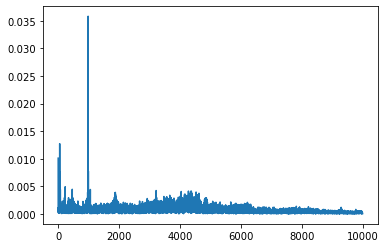

In [11]:
plt.plot(spect[0])

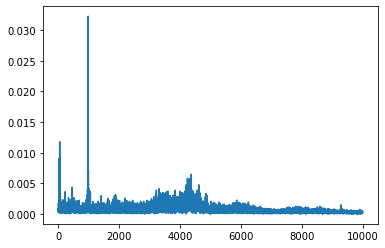

In [12]:
plt.plot(spect[50])

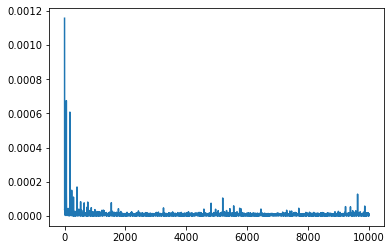

In [13]:
plt.plot(spect[-1])

## 频段能量分布

划分为50个频段，频带宽度为200Hz

In [14]:
power = get_power(spect[:, 1:], 50)

In [15]:
power.shape

(984, 50)

## 标记数据

### 文献依据
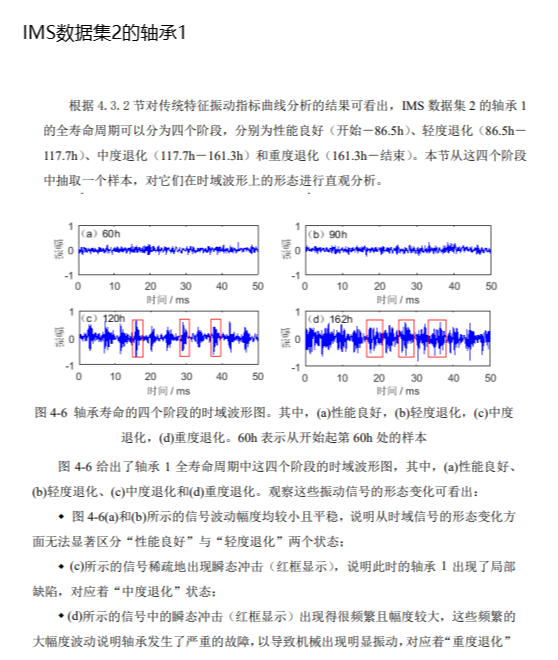

 根据文献，整个劣化过程分为4个阶段：
 * 正常（开始-86.5h）
 * 轻度劣化（86.5h-117.7h）
 * 中度劣化（117.7h-161.3h）
 * 重度劣化（161.3h-结束）。

现在应根据这种划分，查看各个阶段的频谱。

In [16]:
time_1 = dt[0] + timedelta(hours=86.5)
time_2 = dt[0] + timedelta(hours=117.7)
time_3 = dt[0] + timedelta(hours=161.3)

In [17]:
time_1, time_2, time_3

(datetime.datetime(2004, 2, 16, 1, 2, 39),
 datetime.datetime(2004, 2, 17, 8, 14, 39),
 datetime.datetime(2004, 2, 19, 3, 50, 39))

因为样本间隔为10分钟，且所有的时刻都是?2分39秒，因此可对3个时间点进行修正。

In [18]:
time_2 -= timedelta(minutes=2)
time_3 += timedelta(minutes=2)

In [19]:
time_1, time_2, time_3

(datetime.datetime(2004, 2, 16, 1, 2, 39),
 datetime.datetime(2004, 2, 17, 8, 12, 39),
 datetime.datetime(2004, 2, 19, 3, 52, 39))

In [20]:
dt[:10]

[datetime.datetime(2004, 2, 12, 10, 32, 39),
 datetime.datetime(2004, 2, 12, 10, 42, 39),
 datetime.datetime(2004, 2, 12, 10, 52, 39),
 datetime.datetime(2004, 2, 12, 11, 2, 39),
 datetime.datetime(2004, 2, 12, 11, 12, 39),
 datetime.datetime(2004, 2, 12, 11, 22, 39),
 datetime.datetime(2004, 2, 12, 11, 32, 39),
 datetime.datetime(2004, 2, 12, 11, 42, 39),
 datetime.datetime(2004, 2, 12, 11, 52, 39),
 datetime.datetime(2004, 2, 12, 12, 2, 39)]

In [21]:
ind_1 = dt.index(time_1)
ind_2 = dt.index(time_2)
ind_3 = dt.index(time_3)

In [22]:
ind_1, ind_2, ind_3

(519, 706, 968)

### 故障时刻定位

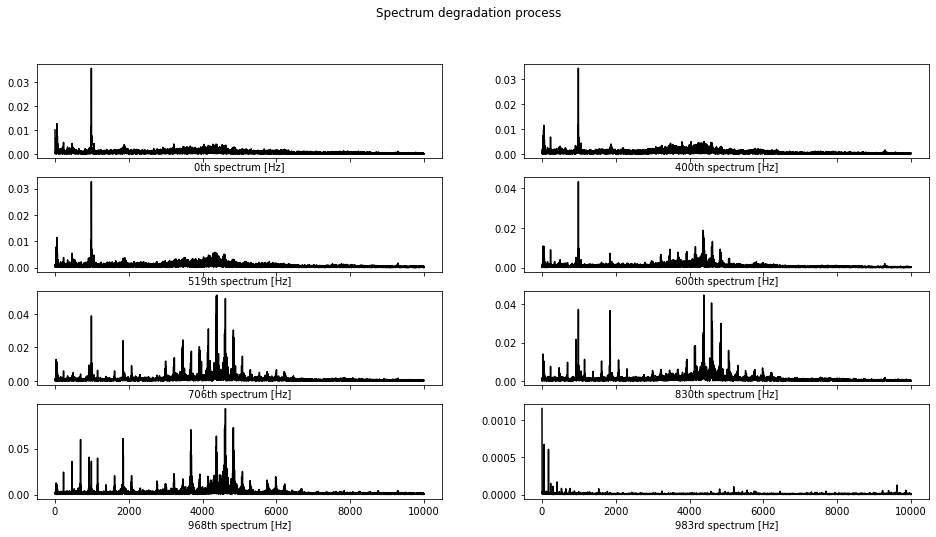

In [80]:
fig, axes = plt.subplots(4, 2, figsize=(16, 8), sharex=True)
for i, ax in zip((0, 400, 519, 600, 706, 830, 968, 983), axes.flatten()):
    ax.plot(spect[i], 'k')
    ax.set_xlabel("{} spectrum [Hz]".format(str(i)+'th' if i % 10 != 3 else str(i)+'rd'))
plt.suptitle('Spectrum degradation process')
plt.savefig('spectrum_1.svg')

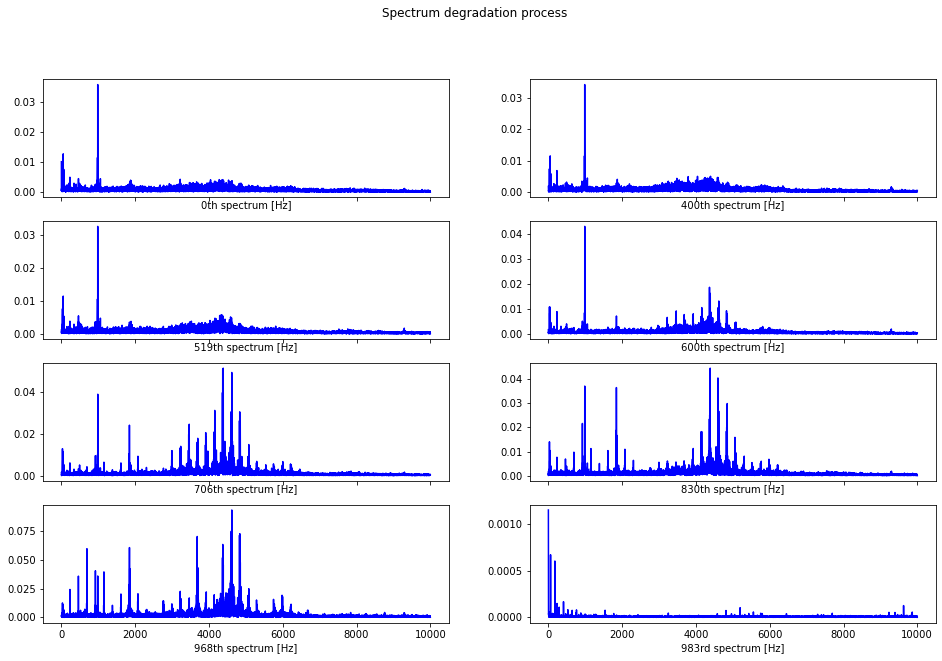

In [81]:
fig, axes = plt.subplots(4, 2, figsize=(16, 10), sharex=True)
for i, ax in zip((0, 400, 519, 600, 706, 830, 968, 983), axes.flatten()):
    ax.plot(spect[i], 'b')
    ax.set_xlabel("{} spectrum [Hz]".format(str(i)+'th' if i % 10 != 3 else str(i)+'rd'))
plt.suptitle('Spectrum degradation process')
plt.savefig("spectrum_2.svg")

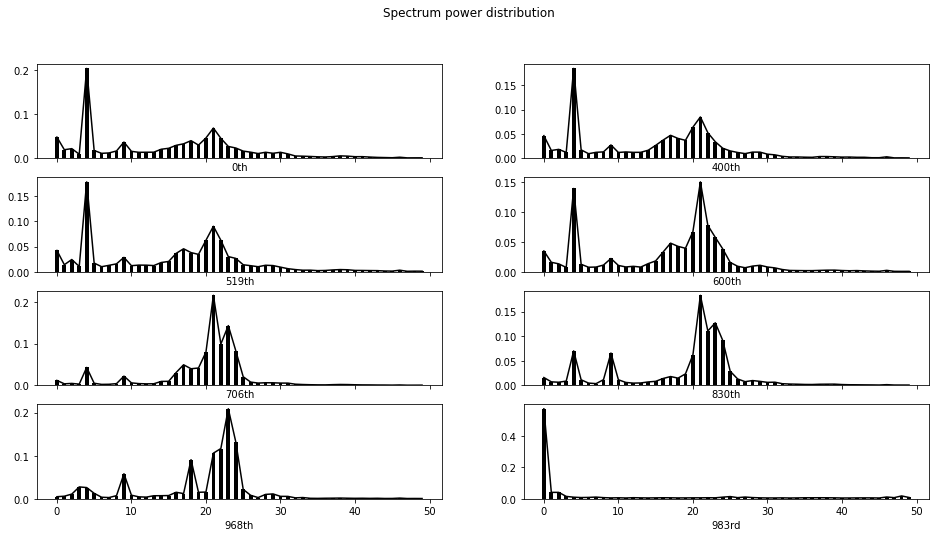

In [82]:
fig, axes = plt.subplots(4, 2, figsize=(16, 8), sharex=True)
for i, ax in zip((0, 400, 519, 600, 706, 830, 968, 983), axes.flatten()):
#     ax.plot(power[i], 'r.')
    ax.plot(power[i], 'k')
    ax.bar(range(50), power[i], width=0.5, color='k')
    ax.set_xlabel("{}".format(str(i)+'th' if i % 10 != 3 else str(i)+'rd'))
plt.suptitle('Spectrum power distribution')
plt.savefig("power_1.svg")

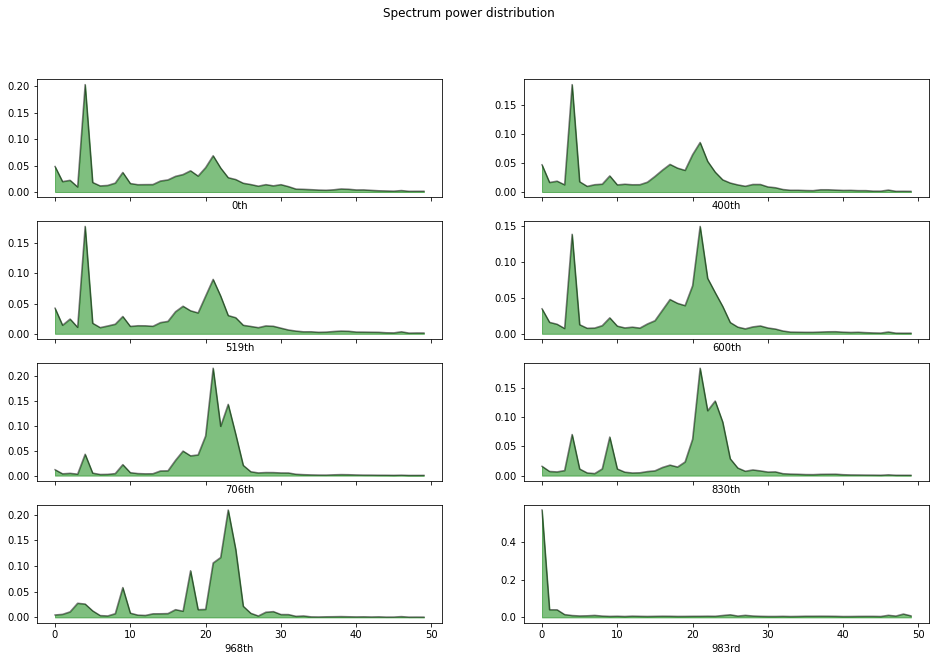

In [83]:
fig, axes = plt.subplots(4, 2, figsize=(16, 10), sharex=True)
for i, ax in zip((0, 400, 519, 600, 706, 830, 968, 983), axes.flatten()):
    ax.plot(power[i], 'k', alpha=0.5)
    ax.fill_between(range(50), 0, power[i], color='g', alpha=0.5)
    ax.set_xlabel("{}".format(str(i)+'th' if i % 10 != 3 else str(i)+'rd'))
plt.suptitle('Spectrum power distribution')
plt.savefig("power_2.svg")

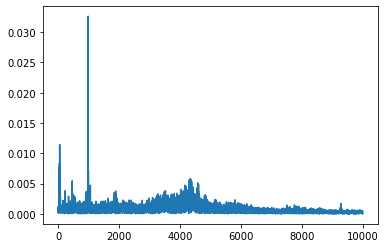

In [27]:
plt.plot(spect[519])

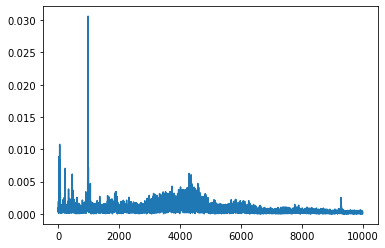

In [28]:
plt.plot(spect[520])

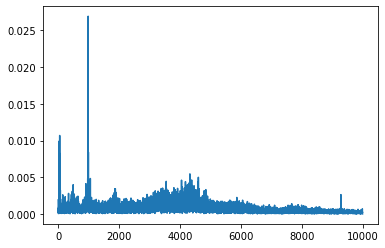

In [29]:
plt.plot(spect[500])

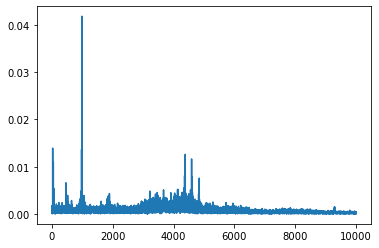

In [30]:
plt.plot(spect[534])

可见，异常并没有明确的临界点。因此标签的设置是困难的问题。

### 设置标签

In [31]:
target = np.ones(len(spect), dtype=np.int8)
target[:520] = 0

## 建模

### 孤立森林
孤立森林事实上是一种无监督的离群值检测算法。它要求训练集中有一定比例的离群值。默认比例为0.1，到底如何正确使用孤立森林，事实上并非那么简单，需要对算法有深刻的理解。

In [32]:
def transform_label(y):
    return (y == -1).astype(np.int8)

In [33]:
from sklearn.ensemble import IsolationForest

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

In [35]:
X_train = power[:200]
y_train = target[:200]
X_test = power[200:]
y_test = target[200:]

In [36]:
isof = IsolationForest(contamination=0.1).fit(X_train)

In [37]:
isof_pred = [transform_label(isof.predict(X)) for X in (X_train, X_test)]

In [38]:
confusion_matrix(y_train, isof_pred[0])

array([[180,  20],
       [  0,   0]], dtype=int64)

In [39]:
confusion_matrix(y_test, isof_pred[1])

array([[116, 204],
       [  0, 464]], dtype=int64)

In [40]:
isof = IsolationForest(contamination=0.02).fit(X_train)

In [41]:
isof_pred = [transform_label(isof.predict(X)) for X in [X_train, X_test]]

In [42]:
confusion_matrix(y_train, isof_pred[0])

array([[196,   4],
       [  0,   0]], dtype=int64)

In [43]:
confusion_matrix(y_test, isof_pred[1])

array([[292,  28],
       [  6, 458]], dtype=int64)

In [44]:
recall_score(y_test, isof_pred[1])

0.9870689655172413

In [45]:
precision_score(y_test, isof_pred[1])

0.9423868312757202

### 一分类支持向量机

一分类支持向量机和随机森林有些类似，通过nu参数控制决策边界。

In [46]:
from sklearn.svm import OneClassSVM

In [47]:
osvm = OneClassSVM()

In [48]:
osvm.fit(X_train)

OneClassSVM()

In [49]:
osvm_pred = [transform_label(osvm.predict(X)) for X in [X_train, X_test]]

In [50]:
confusion_matrix(y_train, osvm_pred[0])

array([[100, 100],
       [  0,   0]], dtype=int64)

In [51]:
confusion_matrix(y_test, osvm_pred[1])

array([[117, 203],
       [  0, 464]], dtype=int64)

In [52]:
osvm = OneClassSVM(nu=0.01).fit(X_train)

In [53]:
osvm_pred = [transform_label(osvm.predict(X)) for X in [X_train, X_test]]

In [54]:
confusion_matrix(y_train, osvm_pred[0])

array([[198,   2],
       [  0,   0]], dtype=int64)

In [55]:
confusion_matrix(y_test, osvm_pred[1])

array([[304,  16],
       [  8, 456]], dtype=int64)

In [56]:
recall_score(y_test, osvm_pred[1])

0.9827586206896551

In [57]:
precision_score(y_test, osvm_pred[1])

0.9661016949152542

### 密度方法

In [58]:
from estimator import SimpleOD

In [59]:
dbod = SimpleOD(k=5)

In [60]:
dbod.fit(X_train)

In [61]:
dbod_pred = [dbod.predict(X) for X in [X_train, X_test]]

In [62]:
confusion_matrix(y_train, dbod_pred[0])

array([[199,   1],
       [  0,   0]], dtype=int64)

In [63]:
confusion_matrix(y_test, dbod_pred[1])

array([[317,   3],
       [ 12, 452]], dtype=int64)

In [64]:
precision_score(y_test, dbod_pred[1])

0.9934065934065934

In [65]:
recall_score(y_test, dbod_pred[1])

0.9741379310344828

手动设置阈值，需要训练集包含一定数量的异常值。

In [66]:
X_train, X_test = power[:600], power[600:]
y_train, y_test = target[:600], target[600:]

In [67]:
dbod = SimpleOD(k=3.5)

In [68]:
dbod.fit(X_train)

In [69]:
dbod.predict(X_train)

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [70]:
dbod.predict(X_test)

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### 内省
查看具体的异常频带

In [71]:
dbod._predict(X_test[50])

array([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1], dtype=int8)

In [72]:
dbod._predict(X_test[0])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int8)

In [73]:
dbod_pred = [dbod.predict(X) for X in [X_train, X_test]]

In [74]:
accuracy_score(y_train, dbod_pred[0])

0.88

In [75]:
confusion_matrix(y_train, dbod_pred[0])

array([[504,  16],
       [ 56,  24]], dtype=int64)

In [76]:
accuracy_score(y_test, dbod_pred[1])

0.9921875

In [77]:
confusion_matrix(y_test, dbod_pred[1])

array([[  0,   0],
       [  3, 381]], dtype=int64)

In [78]:
recall_score(y_test, dbod_pred[1])

0.9921875

In [79]:
precision_score(y_test, dbod_pred[1])

1.0

# 总结

1. 频谱能量分布是识别频谱异常的一个良好特征，但它智能识别能量分布的异常变化，相较于简单的频带能量总值，不够灵敏，有一定的局限性。
2. 劣化数据的标记是困难的，并没有明显的临界点。处于正常和异常之间的数据的处理会影响最终的模型评估效果。
3. 经典异常检测算法，如随机森林和一分类支持向量机的使用，并不简单。尤其是contamination参数的设置和效果，尚需深入研究。
4. 似乎随机森林和一分类支持向量机在不含有异常的数据集上进行训练才能取得比较好的效果（nu和contamination参数取很小的参数）。
5. 简单的基于$\sigma$准则的方法，更简单，容易理解。但是缺点是需要手动设置阈值，训练集中必须包含一定的异常数据。不然决策边界无法确定。实时上，随机森林和一分类支持向量机也是如此。